<a href="https://colab.research.google.com/github/Raman-Luhach/aiStudio/blob/main/cifar10_cnn_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# Enhanced data augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [ ]:
# Load full CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(f'Training samples: {len(trainset)}')
print(f'Test samples: {len(testset)}')

Training samples: 50000
Test samples: 10000


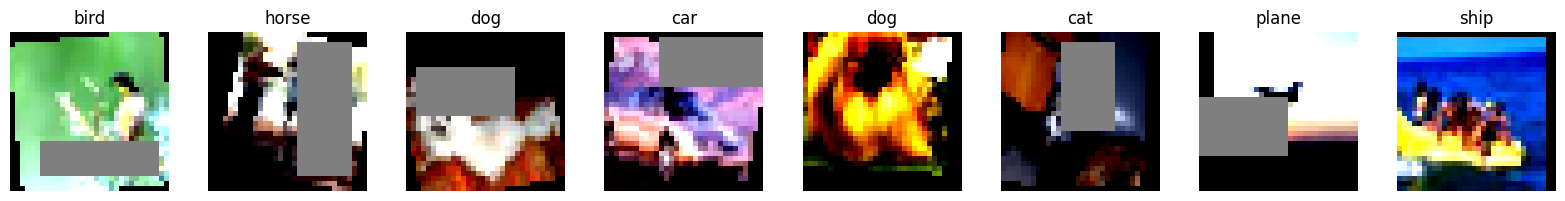

In [ ]:
# Visualize samples
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

dataiter = iter(trainloader)
images, labels = next(dataiter)

fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for i in range(8):
    axes[i].imshow(np.transpose(images[i].numpy() / 2 + 0.5, (1, 2, 0)))
    axes[i].set_title(classes[labels[i]])
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
def train_model(model, trainloader, criterion, optimizer, epochs=10):
    model.train()
    train_losses = []
    train_accs = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs}')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({'loss': running_loss/len(trainloader), 'acc': 100.*correct/total})

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

    return train_losses, train_accs

In [ ]:
def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    class_correct = [0] * 10
    class_total = [0] * 10

    with torch.no_grad():
        for images, labels in tqdm(testloader, desc='Evaluating'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += (predicted[i] == label).item()
                class_total[label] += 1

    accuracy = 100. * correct / total
    print(f'\nOverall Accuracy: {accuracy:.2f}%')
    print('\nPer-class Accuracy:')
    for i in range(10):
        if class_total[i] > 0:
            print(f'{classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')

    return accuracy

In [ ]:
def plot_training(train_losses, train_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(train_losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2.plot(train_accs)
    ax2.set_title('Training Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

=== Experiment 1: Baseline CNN ===


Epoch 15/15: 100%|██████████| 391/391 [00:41<00:00,  9.47it/s, loss=0.987, acc=65.6]


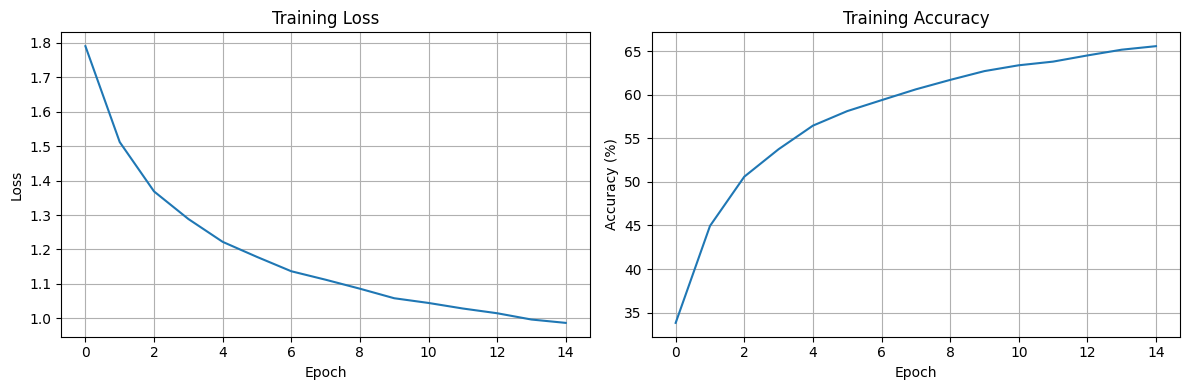

Evaluating: 100%|██████████| 79/79 [00:03<00:00, 25.05it/s]


Overall Accuracy: 75.12%

Per-class Accuracy:
plane: 82.00%
car: 87.80%
bird: 59.10%
cat: 49.30%
deer: 76.60%
dog: 73.10%
frog: 79.40%
horse: 77.30%
ship: 82.50%
truck: 84.10%


In [ ]:
print('=== Experiment 1: Baseline CNN ===')
model1 = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

losses1, accs1 = train_model(model1, trainloader, criterion, optimizer1, epochs=15)
plot_training(losses1, accs1)
acc1 = evaluate_model(model1, testloader)


=== Experiment 2: Higher Learning Rate ===


Epoch 15/15: 100%|██████████| 391/391 [00:39<00:00,  9.96it/s, loss=1.88, acc=30.1]


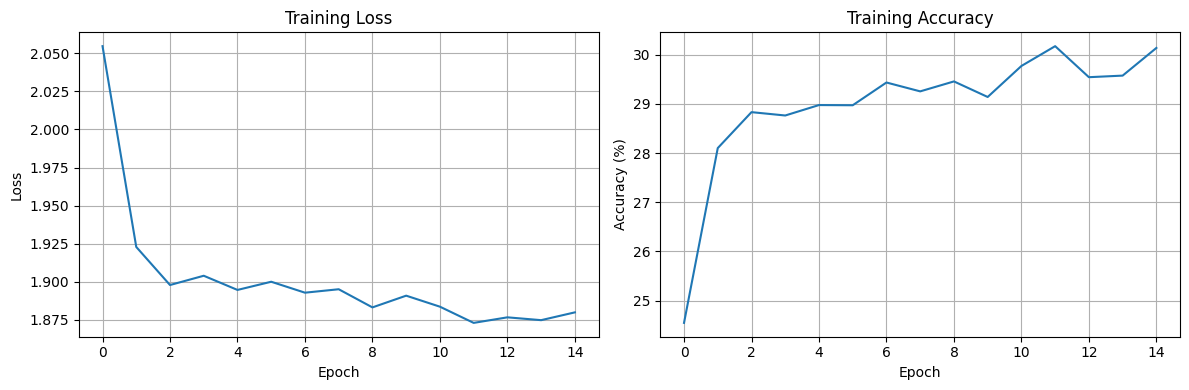

Evaluating: 100%|██████████| 79/79 [00:02<00:00, 26.87it/s]


Overall Accuracy: 37.12%

Per-class Accuracy:
plane: 37.60%
car: 48.70%
bird: 27.90%
cat: 21.00%
deer: 26.40%
dog: 14.90%
frog: 50.10%
horse: 49.80%
ship: 47.80%
truck: 47.00%


In [ ]:
# Experiment 2: CNN with higher learning rate
print('\n=== Experiment 2: Higher Learning Rate ===')
model2 = SimpleCNN().to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=0.01)

losses2, accs2 = train_model(model2, trainloader, criterion, optimizer2, epochs=15)
plot_training(losses2, accs2)
acc2 = evaluate_model(model2, testloader)


=== Experiment 3: SGD with Momentum ===


Epoch 15/15: 100%|██████████| 391/391 [00:41<00:00,  9.42it/s, loss=1, acc=65]


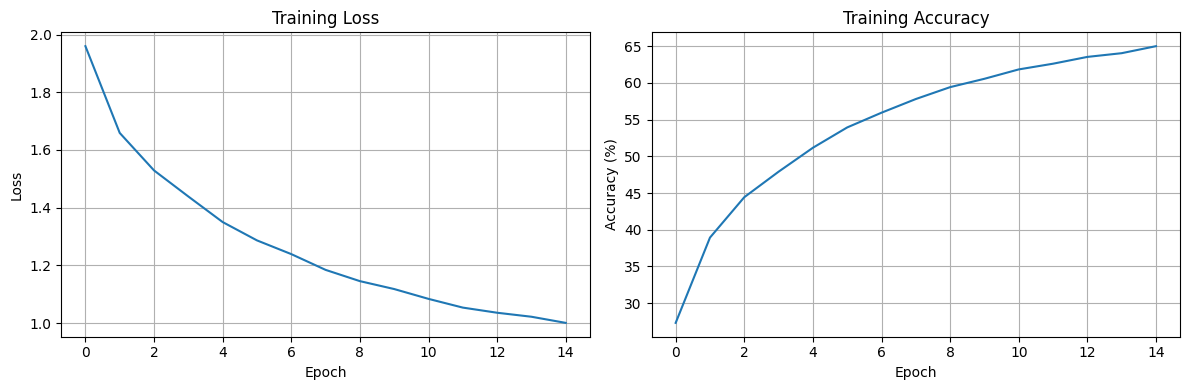

Evaluating: 100%|██████████| 79/79 [00:03<00:00, 25.54it/s]


Overall Accuracy: 73.30%

Per-class Accuracy:
plane: 74.40%
car: 93.30%
bird: 69.30%
cat: 48.20%
deer: 50.60%
dog: 73.50%
frog: 86.10%
horse: 77.40%
ship: 83.80%
truck: 76.40%


In [ ]:
# Experiment 3: CNN with SGD and momentum
print('\n=== Experiment 3: SGD with Momentum ===')
model3 = SimpleCNN().to(device)
optimizer3 = optim.SGD(model3.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

losses3, accs3 = train_model(model3, trainloader, criterion, optimizer3, epochs=15)
plot_training(losses3, accs3)
acc3 = evaluate_model(model3, testloader)


=== Experiment 4: Deeper CNN with BatchNorm ===


Epoch 15/15: 100%|██████████| 391/391 [00:43<00:00,  9.03it/s, loss=0.8, acc=72.8]


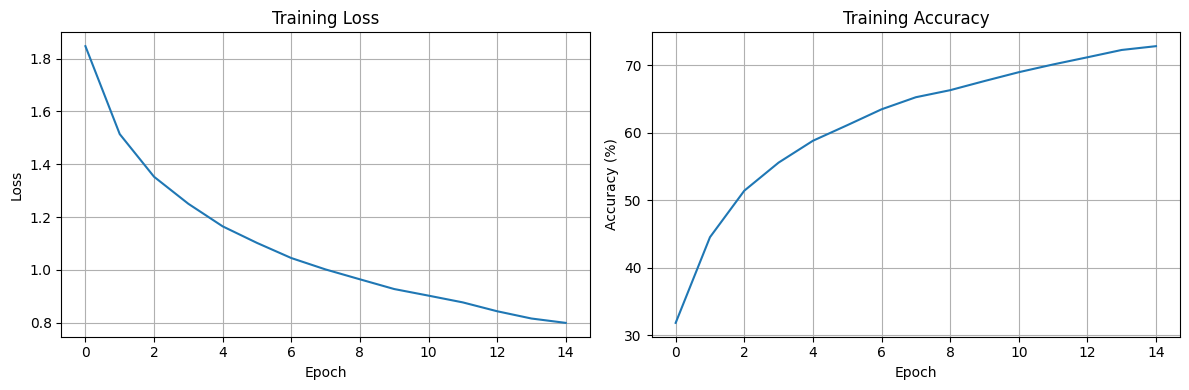

Evaluating: 100%|██████████| 79/79 [00:03<00:00, 24.35it/s]


Overall Accuracy: 11.47%

Per-class Accuracy:
plane: 1.10%
car: 0.00%
bird: 94.30%
cat: 0.00%
deer: 0.00%
dog: 0.00%
frog: 19.30%
horse: 0.00%
ship: 0.00%
truck: 0.00%


In [ ]:
# Experiment 4: Deeper CNN
class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(self.relu(self.bn1(self.conv2(x))))
        x = self.relu(self.bn2(self.conv3(x)))
        x = self.pool(self.relu(self.bn2(self.conv4(x))))
        x = self.pool(self.relu(self.bn3(self.conv5(x))))
        x = x.view(-1, 256 * 4 * 4)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

print('\n=== Experiment 4: Deeper CNN with BatchNorm ===')
model4 = DeeperCNN().to(device)
optimizer4 = optim.Adam(model4.parameters(), lr=0.001)

losses4, accs4 = train_model(model4, trainloader, criterion, optimizer4, epochs=15)
plot_training(losses4, accs4)
acc4 = evaluate_model(model4, testloader)

## Experiment 5: Dropout Regularization

**Why Dropout?** Dropout randomly deactivates neurons during training, forcing the network to learn redundant representations. This prevents co-adaptation of features and reduces overfitting.

**Expected Effect:** Dropout should reduce the gap between training and test accuracy by preventing the model from memorizing training data.


=== Experiment 5a: CNN without Dropout ===


Epoch 15/15: 100%|██████████| 391/391 [00:39<00:00,  9.86it/s, loss=0.813, acc=71.3]


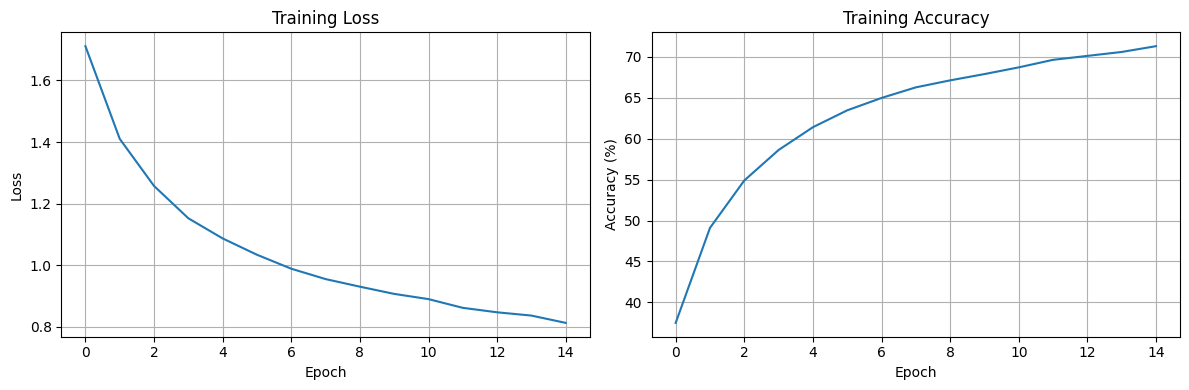

Evaluating: 100%|██████████| 79/79 [00:03<00:00, 23.08it/s]



Overall Accuracy: 77.78%

Per-class Accuracy:
plane: 82.40%
car: 94.00%
bird: 70.80%
cat: 62.90%
deer: 74.80%
dog: 69.30%
frog: 81.40%
horse: 79.10%
ship: 86.70%
truck: 76.40%

=== Experiment 5b: CNN with Dropout (p=0.5) ===


Epoch 15/15: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s, loss=1.01, acc=65]


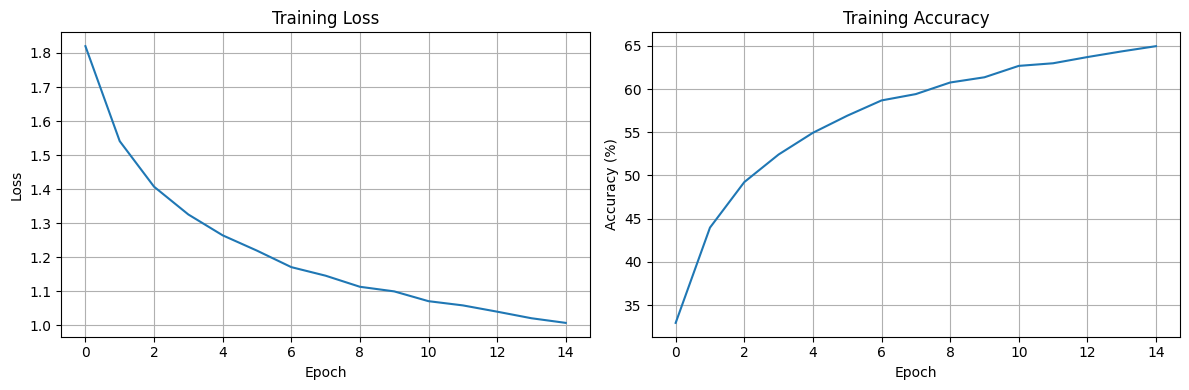

Evaluating: 100%|██████████| 79/79 [00:03<00:00, 20.82it/s]


Overall Accuracy: 74.31%

Per-class Accuracy:
plane: 74.10%
car: 86.90%
bird: 58.80%
cat: 58.20%
deer: 70.40%
dog: 69.40%
frog: 81.60%
horse: 74.00%
ship: 90.70%
truck: 79.00%


In [ ]:
# CNN without Dropout (true baseline)
class CNN_without_Dropout(nn.Module):
    def __init__(self):
        super(CNN_without_Dropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# CNN with Dropout (p=0.5)
class CNN_with_Dropout(nn.Module):
    def __init__(self):
        super(CNN_with_Dropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

print('\n=== Experiment 5a: CNN without Dropout ===')
model5a = CNN_without_Dropout().to(device)
optimizer5a = optim.Adam(model5a.parameters(), lr=0.001)

losses5a, accs5a = train_model(model5a, trainloader, criterion, optimizer5a, epochs=15)
plot_training(losses5a, accs5a)
acc5a = evaluate_model(model5a, testloader)

print('\n=== Experiment 5b: CNN with Dropout (p=0.5) ===')
model5b = CNN_with_Dropout().to(device)
optimizer5b = optim.Adam(model5b.parameters(), lr=0.001)

losses5b, accs5b = train_model(model5b, trainloader, criterion, optimizer5b, epochs=15)
plot_training(losses5b, accs5b)
acc5b = evaluate_model(model5b, testloader)


=== Dropout Comparison ===
Without Dropout: 77.78%
With Dropout (p=0.5): 74.31%
Difference: -3.47%

=== Dropout Comparison ===
Without Dropout: 77.78%
With Dropout (p=0.5): 74.31%
Difference: -3.47%


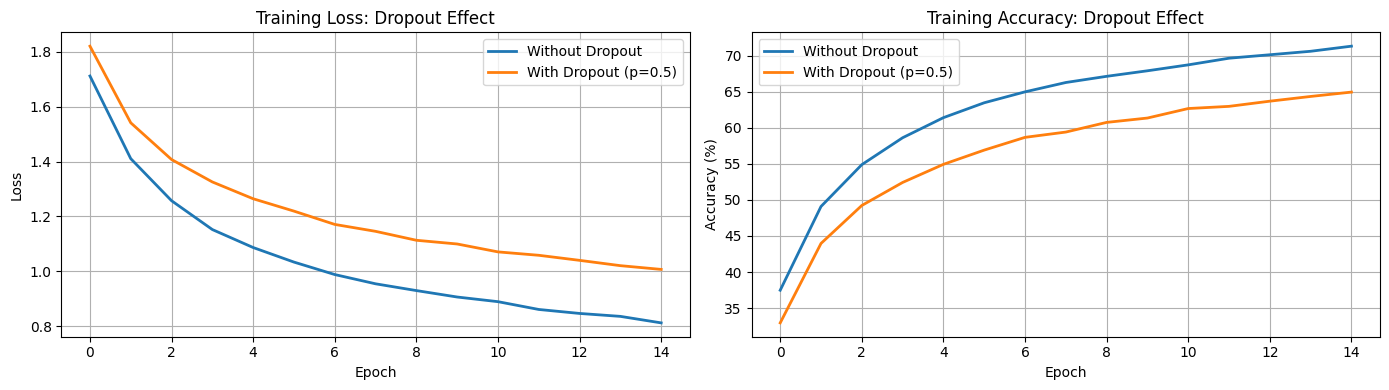

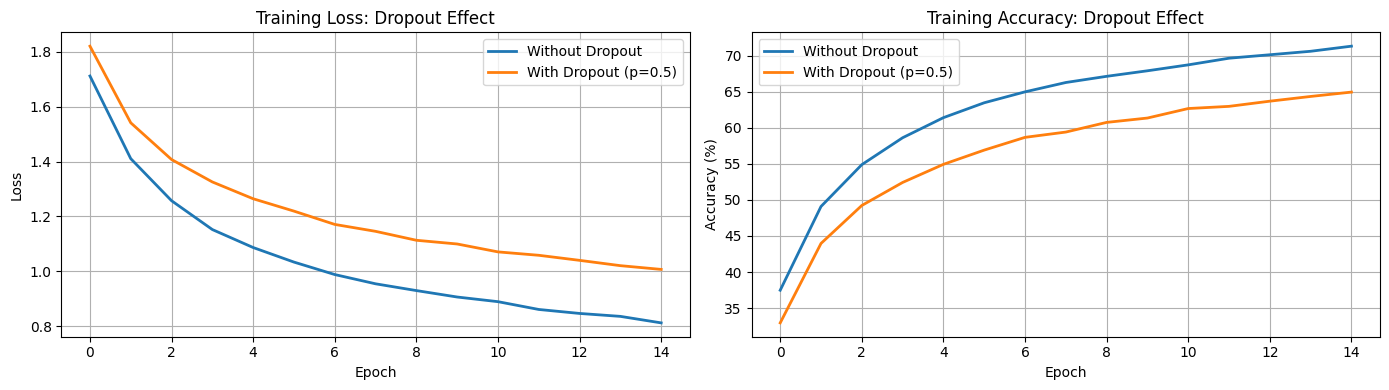

In [ ]:
# Compare Dropout vs No Dropout
print('\n=== Dropout Comparison ===')
print(f'Without Dropout: {acc5a:.2f}%')
print(f'With Dropout (p=0.5): {acc5b:.2f}%')
print(f'Difference: {acc5b - acc5a:+.2f}%')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.plot(losses5a, label='Without Dropout', linewidth=2)
ax1.plot(losses5b, label='With Dropout (p=0.5)', linewidth=2)
ax1.set_title('Training Loss: Dropout Effect')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(accs5a, label='Without Dropout', linewidth=2)
ax2.plot(accs5b, label='With Dropout (p=0.5)', linewidth=2)
ax2.set_title('Training Accuracy: Dropout Effect')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### Key Findings

**Dropout Effect on Overfitting:**
- Dropout acts as an ensemble method by randomly dropping neurons during training
- The model without dropout may achieve higher training accuracy but risks overfitting
- With dropout (p=0.5), 50% of neurons are randomly deactivated each forward pass, preventing feature co-adaptation
- This typically results in better generalization to unseen test data
- Training may appear slower/noisier with dropout, but final test accuracy often improves

## Experiment 6: ResNet Architecture

ResNet (Residual Network) uses skip connections that allow gradients to flow directly through the network, enabling much deeper architectures without vanishing gradient problems.


=== Experiment 6: ResNet-18 ===

=== Experiment 6: ResNet-18 ===


Epoch 1/15: 100%|██████████| 391/391 [00:53<00:00,  7.33it/s, loss=1.65, acc=38.9, lr=0.001]

Epoch 2/15: 100%|██████████| 391/391 [00:51<00:00,  7.53it/s, loss=1.3, acc=52.7, lr=0.000989]

Epoch 3/15: 100%|██████████| 391/391 [00:52<00:00,  7.51it/s, loss=1.15, acc=58.9, lr=0.000957]

Epoch 4/15: 100%|██████████| 391/391 [00:52<00:00,  7.48it/s, loss=1.04, acc=63, lr=0.000905]

Epoch 5/15: 100%|██████████| 391/391 [00:52<00:00,  7.49it/s, loss=0.933, acc=67.2, lr=0.000835]

Epoch 6/15: 100%|██████████| 391/391 [00:52<00:00,  7.49it/s, loss=0.848, acc=70.1, lr=0.00075]

Epoch 7/15: 100%|██████████| 391/391 [00:52<00:00,  7.51it/s, loss=0.768, acc=73.1, lr=0.000655]

Epoch 8/15: 100%|██████████| 391/391 [00:52<00:00,  7.52it/s, loss=0.704, acc=75.6, lr=0.000552]

Epoch 9/15: 100%|██████████| 391/391 [00:52<00:00,  7.47it/s, loss=0.646, acc=77.8, lr=0.000448]

Epoch 10/15: 100%|██████████| 391/391 [00:52<00:00,  7.50it/s, loss=0.589, acc=79.5, lr=0.000345]

Epoch 11/15: 100%|██████████| 

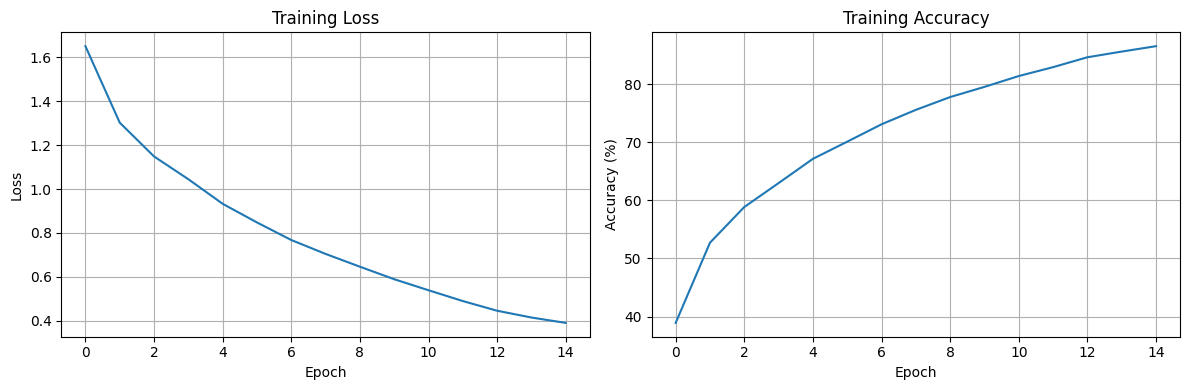

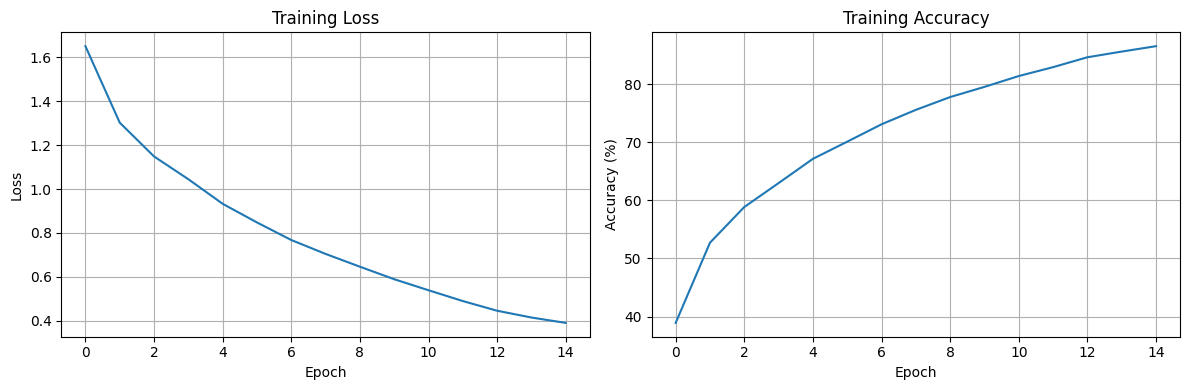

Evaluating: 100%|██████████| 79/79 [00:03<00:00, 20.47it/s]


Overall Accuracy: 89.21%

Per-class Accuracy:
plane: 90.10%
car: 95.60%
bird: 83.90%
cat: 78.00%
deer: 90.80%
dog: 82.10%
frog: 91.60%
horse: 90.60%
ship: 94.50%
truck: 94.90%

Overall Accuracy: 89.21%

Per-class Accuracy:
plane: 90.10%
car: 95.60%
bird: 83.90%
cat: 78.00%
deer: 90.80%
dog: 82.10%
frog: 91.60%
horse: 90.60%
ship: 94.50%
truck: 94.90%


In [ ]:
# ResNet Basic Block
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(identity)
        out = self.relu(out)
        return out

# ResNet-18 for CIFAR-10
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

print('\n=== Experiment 6: ResNet-18 ===')
model6 = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer6 = optim.Adam(model6.parameters(), lr=0.001, weight_decay=5e-4)
scheduler6 = optim.lr_scheduler.CosineAnnealingLR(optimizer6, T_max=15)

# Training with LR scheduler
model6.train()
train_losses6 = []
train_accs6 = []

for epoch in range(15):
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(trainloader, desc=f'Epoch {epoch+1}/15')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer6.zero_grad()
        outputs = model6(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer6.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': running_loss/len(trainloader), 'acc': 100.*correct/total, 'lr': optimizer6.param_groups[0]['lr']})

    scheduler6.step()
    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100. * correct / total
    train_losses6.append(epoch_loss)
    train_accs6.append(epoch_acc)

losses6, accs6 = train_losses6, train_accs6
plot_training(losses6, accs6)
acc6 = evaluate_model(model6, testloader)


=== Summary ===
Experiment 1 (Baseline): 75.12%
Experiment 2 (Higher LR): 37.12%
Experiment 3 (SGD+Momentum): 73.30%
Experiment 4 (Deeper+BN): 11.47%
Experiment 5 (Dropout): 74.31%
Experiment 6 (ResNet-18): 89.21%


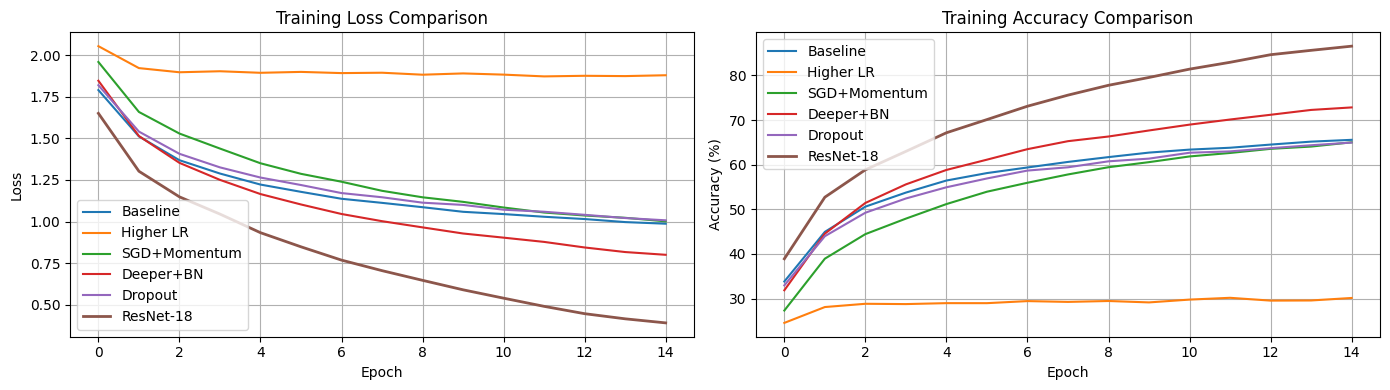

In [19]:
# Compare all experiments
print('\n=== Summary ===')
print(f'Experiment 1 (Baseline): {acc1:.2f}%')
print(f'Experiment 2 (Higher LR): {acc2:.2f}%')
print(f'Experiment 3 (SGD+Momentum): {acc3:.2f}%')
print(f'Experiment 4 (Deeper+BN): {acc4:.2f}%')
print(f'Experiment 5 (Dropout): {acc5b:.2f}%')
print(f'Experiment 6 (ResNet-18): {acc6:.2f}%')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.plot(losses1, label='Baseline')
ax1.plot(losses2, label='Higher LR')
ax1.plot(losses3, label='SGD+Momentum')
ax1.plot(losses4, label='Deeper+BN')
ax1.plot(losses5b, label='Dropout')
ax1.plot(losses6, label='ResNet-18', linewidth=2)
ax1.set_title('Training Loss Comparison')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(accs1, label='Baseline')
ax2.plot(accs2, label='Higher LR')
ax2.plot(accs3, label='SGD+Momentum')
ax2.plot(accs4, label='Deeper+BN')
ax2.plot(accs5b, label='Dropout')
ax2.plot(accs6, label='ResNet-18', linewidth=2)
ax2.set_title('Training Accuracy Comparison')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


Predictions from best model:


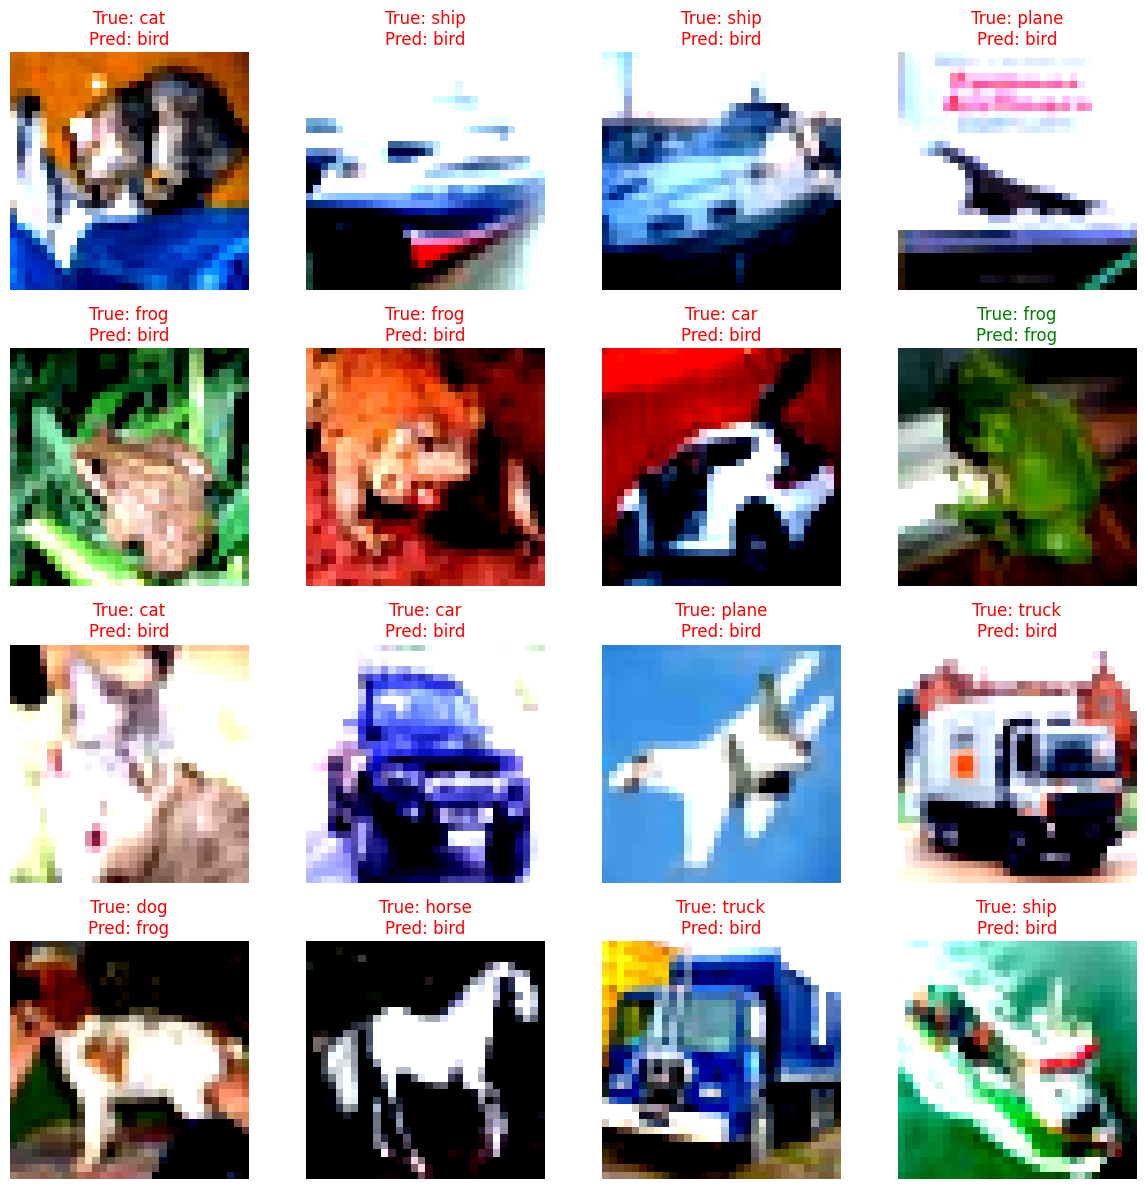

In [20]:
# Visualize predictions
def visualize_predictions(model, testloader, num_images=16):
    model.eval()
    images, labels = next(iter(testloader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = outputs.max(1)

    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()

    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    for i in range(num_images):
        ax = axes[i // 4, i % 4]
        img = images[i] / 2 + 0.5
        ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        color = 'green' if predicted[i] == labels[i] else 'red'
        ax.set_title(f'True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}', color=color)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

print('\nPredictions from best model:')
visualize_predictions(model4, testloader)